,ME,RMSE,MAE
Insample,-0.000,1.866,1.415
Outsample,0.236,2.097,1.684


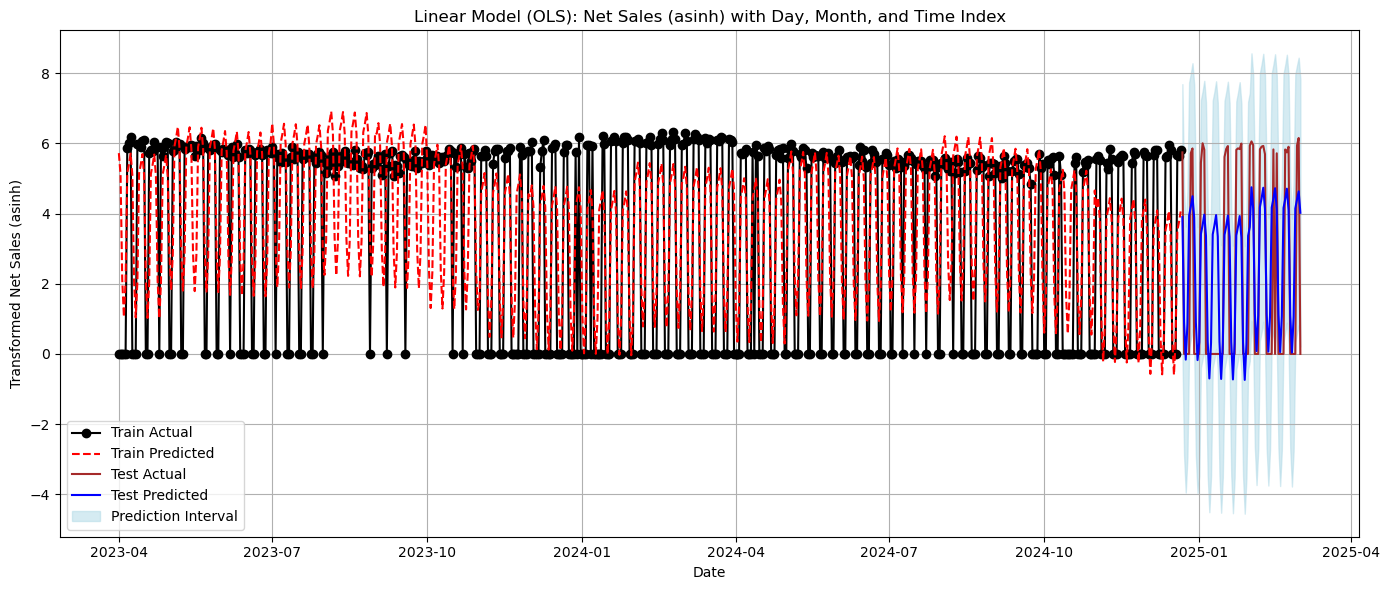

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load and reshape the CSVs ---
df1 = pd.read_csv("SalesSummary 23-24.csv", index_col=0)
df2 = pd.read_csv("SalesSummary 24-25.csv", index_col=0)

# Transpose and stack
df1 = df1.T
df2 = df2.T
df = pd.concat([df1, df2])
df.index.name = 'date'
df.reset_index(inplace=True)

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace(r'[^\w\s]', '', regex=True)

# Parse dates
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')

# Parse currency to numeric
df['Net_Sales'] = pd.to_numeric(df['Net_Sales'].astype(str).str.replace('[\$,]', '', regex=True), errors='coerce')

# Drop missing values
df = df.dropna(subset=['Net_Sales']).sort_values('date')

# --- Feature engineering ---
df['y'] = np.arcsinh(df['Net_Sales'])  # log-like transform
df['day'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['x'] = np.arange(len(df))  # time index

# --- Split into training and testing ---
train_ratio = 0.9
train_size = int(len(df) * train_ratio)
train_data = df.iloc[:train_size].copy()
test_data = df.iloc[train_size:].copy()

# One-hot encode categorical vars
X_train = pd.get_dummies(train_data[['x', 'day', 'month']], drop_first=True)
y_train = train_data['y']

X_test = pd.get_dummies(test_data[['x', 'day', 'month']], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Align columns

# Add intercept for statsmodels
X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm = sm.add_constant(X_test).astype(float)
y_train = y_train.astype(float)

# --- Fit the OLS model ---
ols_model = sm.OLS(y_train, X_train_sm).fit()

# --- In-sample predictions ---
train_preds = ols_model.predict(X_train_sm)
train_data = train_data.loc[X_train.index].copy()
train_data['yhat'] = train_preds
train_data['e'] = train_data['y'] - train_data['yhat']

# --- Out-of-sample predictions with intervals ---
preds = ols_model.get_prediction(X_test_sm)
summary_frame = preds.summary_frame(alpha=0.05)

test_data['fit'] = summary_frame['mean']
test_data['lwr'] = summary_frame['obs_ci_lower']
test_data['upr'] = summary_frame['obs_ci_upper']

# --- Accuracy metrics ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

acc_in = accuracy_metrics(train_data['y'], train_data['yhat']).round(3)
acc_out = accuracy_metrics(test_data['y'], test_data['fit']).round(3)
acc_table = pd.DataFrame([acc_in, acc_out], index=['Insample', 'Outsample'])
display(acc_table)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_data['date'], train_data['y'], label='Train Actual', color='black', marker='o', linestyle='-')
plt.plot(train_data['date'], train_data['yhat'], label='Train Predicted', linestyle='--', color='red')
plt.plot(test_data['date'], test_data['y'], label='Test Actual', color='brown')
plt.plot(test_data['date'], test_data['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data['date'], test_data['lwr'], test_data['upr'], color='lightblue', alpha=0.5, label='Prediction Interval')
plt.title('Linear Model (OLS): Net Sales (asinh) with Day, Month, and Time Index')
plt.xlabel('Date')
plt.ylabel('Transformed Net Sales (asinh)')
plt.legend()
plt.grid(True)
plt.tight_layout()


# --- SAVE: Calendar-only OLS figure ---
plt.tight_layout()

# PNG + SVG (vector). Filenames match the README.
plt.savefig("ols_calendar_forecast.png", dpi=300, bbox_inches="tight")
plt.savefig("ols_calendar_forecast.svg", bbox_inches="tight")

plt.show()
plt.close() 



In [2]:
import numpy as np

# --- Build prediction_range in DOLLARS---
# Priority 1: already-backtransformed dollars
if {'lower_bound_dollars', 'upper_bound_dollars'}.issubset(test_data.columns):
    test_data['prediction_range'] = (
        test_data['upper_bound_dollars'] - test_data['lower_bound_dollars']
    )

# Priority 2: asinh-scale PI from OLS (lags): lwr/upr
elif {'lwr', 'upr'}.issubset(test_data.columns):
    test_data['prediction_range'] = np.sinh(test_data['upr']) - np.sinh(test_data['lwr'])

# Priority 3: asinh-scale PI from OLS (lags + weather): lwr_w/upr_w
elif {'lwr_w', 'upr_w'}.issubset(test_data.columns):
    test_data['prediction_range'] = np.sinh(test_data['upr_w']) - np.sinh(test_data['lwr_w'])

else:
    raise KeyError(
        "Couldn't find prediction interval columns. "
        "Expected one of: "
        "{lower_bound_dollars, upper_bound_dollars} OR {lwr, upr} OR {lwr_w, upr_w}. "
        f"Columns present: {list(test_data.columns)}"
    )


In [3]:
# Average range
mean_range = test_data['prediction_range'].mean()
print(f"📏 Average Prediction Interval Range: ${mean_range:.2f}")

# Summary stats
print(test_data['prediction_range'].describe())


📏 Average Prediction Interval Range: $790.84
count      71.000000
mean      790.842177
std       775.805727
min        44.661458
25%        57.844371
50%       664.676865
75%      1378.001301
max      2613.953046
Name: prediction_range, dtype: float64


In [4]:
# --- Convert calendar-only model predictions back to dollars ---
test_data['actual_dollars'] = np.sinh(test_data['y'])
test_data['predicted_dollars'] = np.sinh(test_data['fit'])
test_data['lower_bound_dollars'] = np.sinh(test_data['lwr'])
test_data['upper_bound_dollars'] = np.sinh(test_data['upr'])

# --- Accuracy in dollars ---
dollar_acc_calendar = accuracy_metrics(test_data['actual_dollars'], test_data['predicted_dollars']).round(2)
print("📊 Calendar-Only Forecast (Dollars):")
print(dollar_acc_calendar)


📊 Calendar-Only Forecast (Dollars):
ME     -49.22
RMSE    89.98
MAE     59.49
dtype: float64


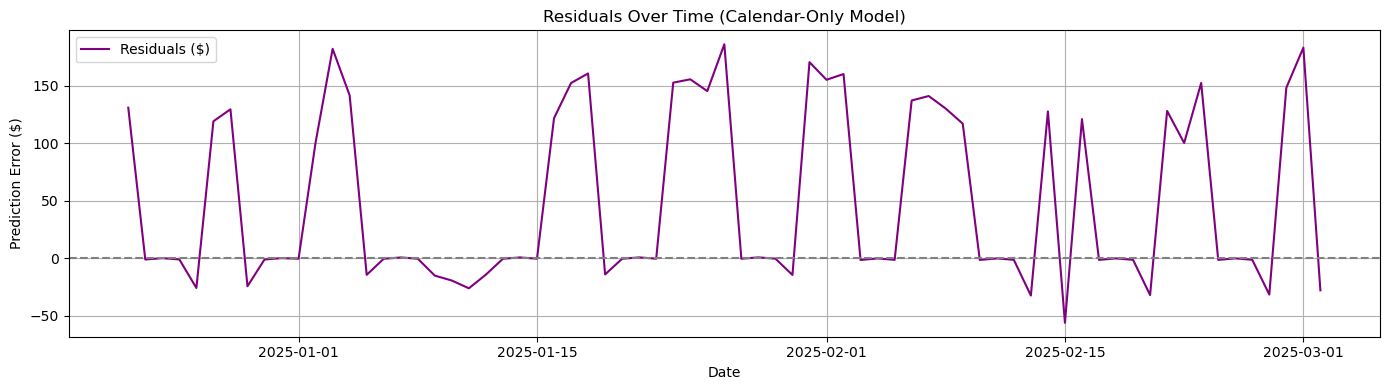

In [5]:
# Plot residuals over time for calendar-only model
plt.figure(figsize=(14, 4))
plt.plot(test_data['date'], test_data['actual_dollars'] - test_data['predicted_dollars'], label='Residuals ($)', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals Over Time (Calendar-Only Model)')
plt.xlabel('Date')
plt.ylabel('Prediction Error ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
coverage = np.mean(
    (test_data['actual_dollars'] >= test_data['lower_bound_dollars']) &
    (test_data['actual_dollars'] <= test_data['upper_bound_dollars'])
)
print(f"Prediction interval coverage (Calendar-only): {coverage:.2%}")


Prediction interval coverage (Calendar-only): 88.73%


In [7]:
tolerance = 20  # dollars
within_range = np.mean(np.abs(test_data['actual_dollars'] - test_data['predicted_dollars']) <= tolerance)
print(f"Percent of forecasts within ±${tolerance}: {within_range:.2%}")


Percent of forecasts within ±$20: 50.70%


In [8]:
# --- Imports ---
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Load and clean sales data ---
df1 = pd.read_csv("SalesSummary 23-24.csv", index_col=0)
df2 = pd.read_csv("SalesSummary 24-25.csv", index_col=0)

df1 = df1.T
df2 = df2.T
df = pd.concat([df1, df2])
df.index.name = 'date'
df.reset_index(inplace=True)

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace(r'[^\w\s]', '', regex=True)

# Parse dates and Net Sales
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')
df['Net_Sales'] = pd.to_numeric(df['Net_Sales'].astype(str).str.replace(r'[\$,]', '', regex=True), errors='coerce')
df = df.dropna(subset=['Net_Sales']).sort_values('date')

# Apply transformation to sales for modeling
df['y'] = np.arcsinh(df['Net_Sales'])

# --- Load and clean weather data ---
weather = pd.read_csv("Weather Data.csv")

# Normalize column names
weather.columns = weather.columns.str.strip().str.upper()

# Rename date column and parse dates
weather.rename(columns={'DATE': 'date'}, inplace=True)
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')

# Clean and convert each weather column
for col in weather.columns:
    if col != 'date':
        weather[col] = (
            weather[col].astype(str)
            .str.replace(r'[\$,]', '', regex=True)
            .str.strip()
        )
        weather[col] = pd.to_numeric(weather[col], errors='coerce')

# --- Merge datasets ---
df_weather = df.merge(weather, on='date', how='left')

# --- Filter valid weather variables ---
weather_vars = [
    col for col in df_weather.columns
    if col not in ['date', 'Net_Sales', 'y']
    and pd.api.types.is_numeric_dtype(df_weather[col])
    and df_weather[col].notna().sum() > 0
    and df_weather[col].nunique() > 1
]

# Drop rows with any missing weather values
df_weather = df_weather.dropna(subset=weather_vars)

# --- Final check ---
if df_weather.empty:
    raise ValueError("No data left after merging and cleaning. Check weather file.")

# --- Build X and y ---
X = df_weather[weather_vars]
X = sm.add_constant(X).astype(float)
y = df_weather['y'].astype(float)

# --- Fit OLS model and print summary ---
ols_weather = sm.OLS(y, X).fit()
print(ols_weather.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     391.9
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:25:15   Log-Likelihood:                -839.60
No. Observations:                 703   AIC:                             1719.
Df Residuals:                     683   BIC:                             1810.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8057      0.15

In [9]:

# --- Add PRCP and TMIN to calendar-based OLS model using statsmodels ---
# Add engineered features needed for regression
df_weather['x'] = np.arange(len(df_weather))
df_weather['day'] = df_weather['date'].dt.day_name()
df_weather['month'] = df_weather['date'].dt.month_name()


import statsmodels.api as sm

# Build design matrix
X = pd.get_dummies(
    df_weather[['x', 'day', 'month']], 
    drop_first=True
)

# Add weather variables
X['PRCP'] = df_weather['PRCP']
X['TMIN'] = df_weather['TMIN']

# Target variable
y = df_weather['y'].astype(float)

# Add constant term
X = sm.add_constant(X).astype(float)

# Fit OLS model
calendar_weather_model = sm.OLS(y, X).fit()

# Display results
print("📊 OLS Model Summary (Calendar + PRCP + TMIN):")
print(calendar_weather_model.summary())


📊 OLS Model Summary (Calendar + PRCP + TMIN):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     38.83
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           1.79e-98
Time:                        17:25:15   Log-Likelihood:                -1442.9
No. Observations:                 703   AIC:                             2928.
Df Residuals:                     682   BIC:                             3024.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

,ME,RMSE,MAE
Insample,-0.000,1.863,1.412
Outsample,0.113,2.090,1.688


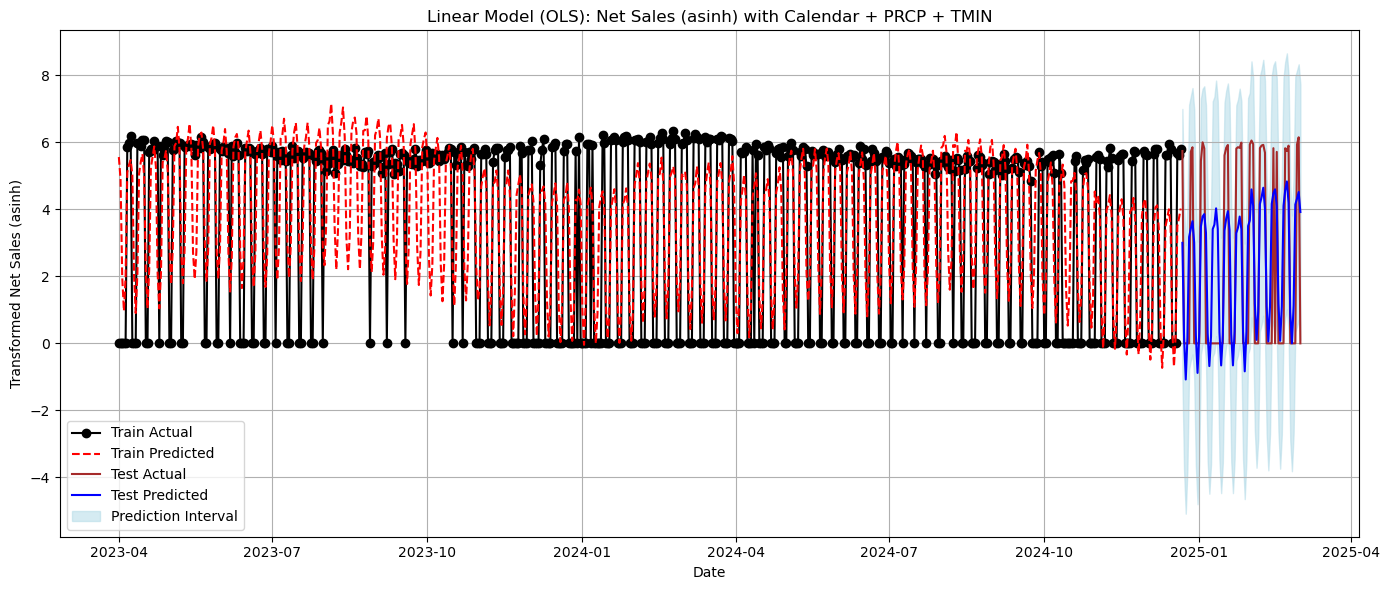

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Train/test split ---
train_ratio = 0.9
train_size = int(len(df_weather) * train_ratio)
train_data_weather = df_weather.iloc[:train_size].copy()
test_data_weather = df_weather.iloc[train_size:].copy()

# --- Build design matrices ---
X_train = pd.get_dummies(train_data_weather[['x', 'day', 'month']], drop_first=True)
X_train['PRCP'] = train_data_weather['PRCP']
X_train['TMIN'] = train_data_weather['TMIN']
y_train = train_data_weather['y'].astype(float)

X_test = pd.get_dummies(test_data_weather[['x', 'day', 'month']], drop_first=True)
X_test['PRCP'] = test_data_weather['PRCP']
X_test['TMIN'] = test_data_weather['TMIN']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Add intercepts
X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm = sm.add_constant(X_test).astype(float)

# --- Fit updated OLS model ---
ols_model_weather = sm.OLS(y_train, X_train_sm).fit()

# --- In-sample predictions ---
train_data_weather['yhat'] = ols_model_weather.predict(X_train_sm)
train_data_weather['e'] = train_data_weather['y'] - train_data_weather['yhat']

# --- Out-of-sample predictions with intervals ---
preds = ols_model_weather.get_prediction(X_test_sm).summary_frame(alpha=0.05)
test_data_weather['fit'] = preds['mean']
test_data_weather['lwr'] = preds['obs_ci_lower']
test_data_weather['upr'] = preds['obs_ci_upper']

# --- Accuracy ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

acc_in = accuracy_metrics(train_data_weather['y'], train_data_weather['yhat']).round(3)
acc_out = accuracy_metrics(test_data_weather['y'], test_data_weather['fit']).round(3)
acc_table_weather = pd.DataFrame([acc_in, acc_out], index=['Insample', 'Outsample'])
display(acc_table_weather)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_data_weather['date'], train_data_weather['y'], label='Train Actual', color='black', marker='o', linestyle='-')
plt.plot(train_data_weather['date'], train_data_weather['yhat'], label='Train Predicted', linestyle='--', color='red')
plt.plot(test_data_weather['date'], test_data_weather['y'], label='Test Actual', color='brown')
plt.plot(test_data_weather['date'], test_data_weather['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data_weather['date'], test_data_weather['lwr'], test_data_weather['upr'], color='lightblue', alpha=0.5, label='Prediction Interval')
plt.title('Linear Model (OLS): Net Sales (asinh) with Calendar + PRCP + TMIN')
plt.xlabel('Date')
plt.ylabel('Transformed Net Sales (asinh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figure2_LinearModel_withWeather.png', dpi=300, bbox_inches='tight')


# --- SAVE: Calendar + Weather OLS figure ---
plt.tight_layout()

plt.savefig("ols_calendar_weather_forecast.png", dpi=300, bbox_inches="tight")
plt.savefig("ols_calendar_weather_forecast.svg", bbox_inches="tight")

plt.show()
plt.close()



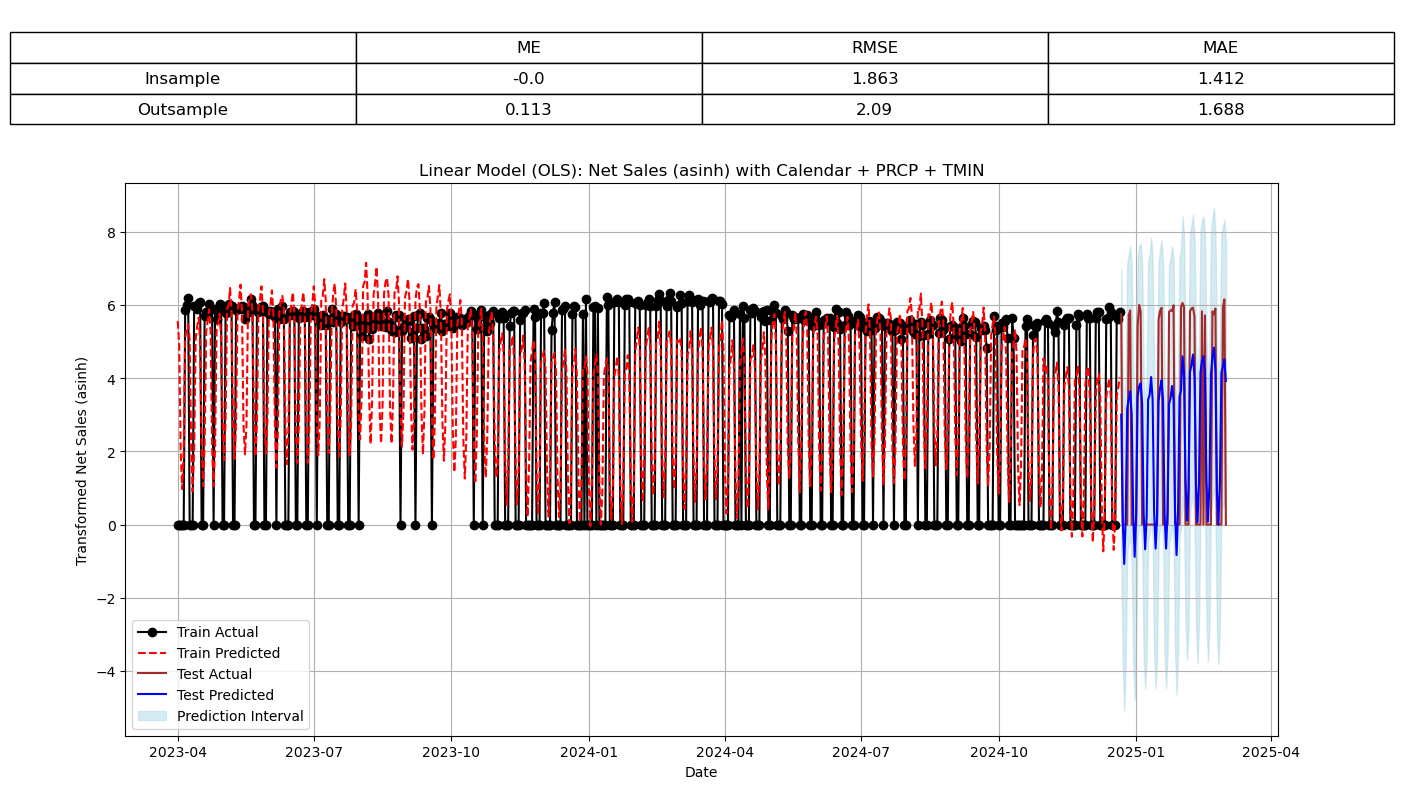

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Set up figure layout ---
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 1, height_ratios=[1, 4])  # table + plot

# --- Table subplot ---
ax_table = fig.add_subplot(gs[0])
ax_table.axis('off')  # Hide axis

# Format and display table
table_data = acc_table_weather.reset_index().values
column_labels = ["", "ME", "RMSE", "MAE"]
table = ax_table.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# --- Plot subplot ---
ax_plot = fig.add_subplot(gs[1])
ax_plot.plot(train_data_weather['date'], train_data_weather['y'], label='Train Actual', color='black', marker='o', linestyle='-')
ax_plot.plot(train_data_weather['date'], train_data_weather['yhat'], label='Train Predicted', linestyle='--', color='red')
ax_plot.plot(test_data_weather['date'], test_data_weather['y'], label='Test Actual', color='brown')
ax_plot.plot(test_data_weather['date'], test_data_weather['fit'], label='Test Predicted', color='blue')
ax_plot.fill_between(test_data_weather['date'], test_data_weather['lwr'], test_data_weather['upr'],
                     color='lightblue', alpha=0.5, label='Prediction Interval')
ax_plot.set_title('Linear Model (OLS): Net Sales (asinh) with Calendar + PRCP + TMIN')
ax_plot.set_xlabel('Date')
ax_plot.set_ylabel('Transformed Net Sales (asinh)')
ax_plot.legend()
ax_plot.grid(True)

# --- Save figure ---
plt.tight_layout()
plt.savefig('Figure2_LinearModel_withWeather_andMetrics.png', dpi=300, bbox_inches='tight')
plt.show()


📊 Calendar + Weather Forecast (Dollars):
ME     -50.80
RMSE    91.46
MAE     59.96
dtype: float64


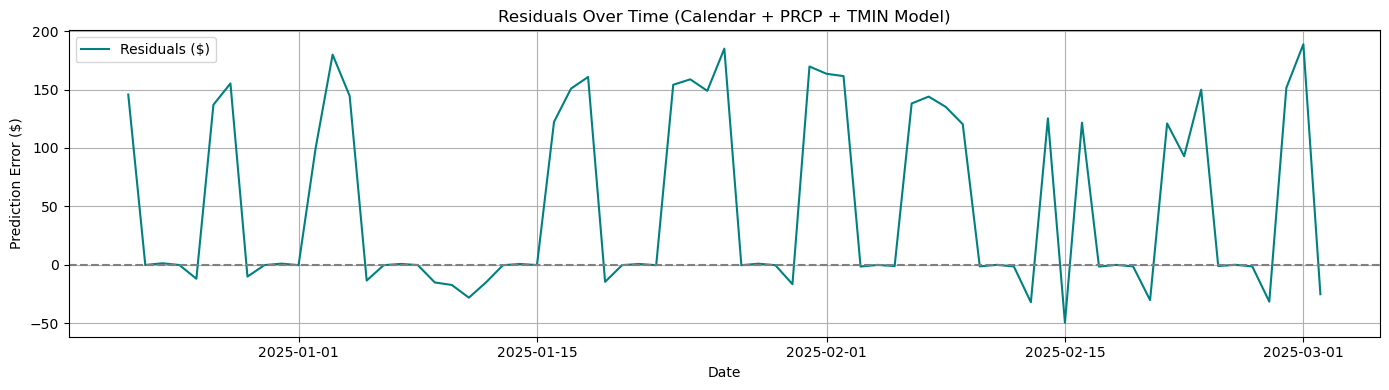

Prediction interval coverage (Calendar + Weather): 91.55%


In [12]:
# --- Convert predictions back to dollars ---
test_data_weather['actual_dollars'] = np.sinh(test_data_weather['y'])
test_data_weather['predicted_dollars'] = np.sinh(test_data_weather['fit'])
test_data_weather['lower_bound_dollars'] = np.sinh(test_data_weather['lwr'])
test_data_weather['upper_bound_dollars'] = np.sinh(test_data_weather['upr'])

# --- Accuracy in dollars ---
dollar_acc_weather = accuracy_metrics(
    test_data_weather['actual_dollars'],
    test_data_weather['predicted_dollars']
).round(2)

print("📊 Calendar + Weather Forecast (Dollars):")
print(dollar_acc_weather)

# --- Residuals plot in dollars ---
plt.figure(figsize=(14, 4))
plt.plot(
    test_data_weather['date'],
    test_data_weather['actual_dollars'] - test_data_weather['predicted_dollars'],
    label='Residuals ($)',
    color='teal'
)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals Over Time (Calendar + PRCP + TMIN Model)')
plt.xlabel('Date')
plt.ylabel('Prediction Error ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

coverage = np.mean(
    (test_data_weather['actual_dollars'] >= test_data_weather['lower_bound_dollars']) &
    (test_data_weather['actual_dollars'] <= test_data_weather['upper_bound_dollars'])
)
print(f"Prediction interval coverage (Calendar + Weather): {coverage:.2%}")





In [13]:
test_data_weather['prediction_range'] = test_data_weather['upper_bound_dollars'] - test_data_weather['lower_bound_dollars']

# Average range
mean_range_weather = test_data_weather['prediction_range'].mean()
print(f"📏 Average Prediction Interval Range: ${mean_range_weather:.2f}")

# Summary stats
print(test_data_weather['prediction_range'].describe())


📏 Average Prediction Interval Range: $734.92
count      71.000000
mean      734.916316
std       737.630728
min        45.469897
25%        55.652122
50%       656.306119
75%      1217.960562
max      2872.969390
Name: prediction_range, dtype: float64


In [14]:
tolerance = 20  # dollars
within_range = np.mean(np.abs(test_data_weather['actual_dollars'] - test_data_weather['predicted_dollars']) <= tolerance)
print(f"Percent of forecasts within ±${tolerance}: {within_range:.2%}")


Percent of forecasts within ±$20: 53.52%
